In [1]:
from monai.data import ArrayDataset, DataLoader, PILReader
import time
import numpy as np
from numpy.lib.stride_tricks import as_strided
from imageio import imsave
import math
import matplotlib.pyplot as plt

from skimage.util import view_as_windows

In [10]:
!ls /data/60x_images/

AssayPlate_Greiner_#655090_B03_T0001F001L01A01Z01C01.tif
AssayPlate_Greiner_#655090_B03_T0001F001L01A02Z01C02.tif
AssayPlate_Greiner_#655090_B03_T0001F001L01A03Z01C03.tif
AssayPlate_Greiner_#655090_B03_T0001F001L01A04Z01C04.tif
AssayPlate_Greiner_#655090_B03_T0001F001L01A04Z02C04.tif
AssayPlate_Greiner_#655090_B03_T0001F001L01A04Z03C04.tif
AssayPlate_Greiner_#655090_B03_T0001F001L01A04Z04C04.tif
AssayPlate_Greiner_#655090_B03_T0001F001L01A04Z05C04.tif
AssayPlate_Greiner_#655090_B03_T0001F001L01A04Z06C04.tif
AssayPlate_Greiner_#655090_B03_T0001F001L01A04Z07C04.tif
AssayPlate_Greiner_#655090_B03_T0001F002L01A01Z01C01.tif
AssayPlate_Greiner_#655090_B03_T0001F002L01A02Z01C02.tif
AssayPlate_Greiner_#655090_B03_T0001F002L01A03Z01C03.tif
AssayPlate_Greiner_#655090_B03_T0001F002L01A04Z01C04.tif
AssayPlate_Greiner_#655090_B03_T0001F002L01A04Z02C04.tif
AssayPlate_Greiner_#655090_B03_T0001F002L01A04Z03C04.tif
AssayPlate_Greiner_#655090_B03_T0001F002L01A04Z04C04.tif
AssayPlate_Greiner_#655090_B03_

In [37]:
p = "/data/60x_images/AssayPlate_Greiner_#655090_B03_T0001F001L01A01Z01C01.tif"
img = PILReader().read(p)
img = np.array(img)

In [38]:
print(img.shape)
print([i/256 for i in img.shape])

(2156, 2556)
[8.421875, 9.984375]


In [39]:
img

array([[189, 200, 260, ...,  26,  30,  28],
       [176, 191, 205, ...,   7,  15,  23],
       [172, 188, 230, ...,  13,   8,  11],
       ...,
       [ 34,  25,  49, ..., 267, 268, 230],
       [ 43,  26,  41, ..., 259, 252, 201],
       [ 37,  46,  31, ..., 206, 266, 270]], dtype=uint16)

In [40]:
img.min(), img.max()

(0, 6243)

In [41]:
img = (np.log(1+img) - 5.5)/5.5

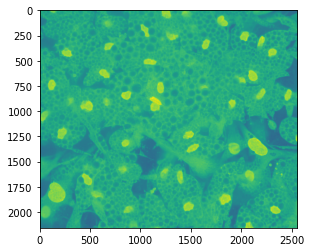

In [42]:
plt.imshow(img)

In [43]:
img[img<-0.1] = 0.0

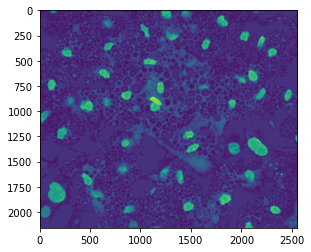

In [44]:
plt.imshow(img)

In [6]:
# Patchify parameters
img_h, img_w = img.shape
patch_size = 256
overlap_ratio = 0.5
overlap = int(overlap_ratio*patch_size)
nonoverlap = int((1-overlap_ratio)*patch_size)

num_grids_h = math.ceil(img_h/nonoverlap)
num_grids_w = math.ceil(img_w/nonoverlap)

num_grids_h, num_grids_w

(17, 20)

In [7]:
# Patch generation
img_patches = []

for h in range(num_grids_h):
    for w in range(num_grids_w):
        slice_h_start = 0
        slice_w_start = 0
        
        if h == (num_grids_h-1) and w == (num_grids_w-1):
            slice_h_start = img_h
            slice_w_start = img_w
        elif h == (num_grids_h-1):
            slice_h_end = img_h
            slice_w_end = min(nonoverlap*w + patch_size, img_w)
        elif w == (num_grids_w-1):
            slice_h_end = min(nonoverlap*h + patch_size, img_h)
            slice_w_end = img_w
        else:
            slice_h_end = min(nonoverlap*h + patch_size, img_h)
            slice_w_end = min(nonoverlap*w + patch_size, img_w)
            
        slice_h_start = slice_h_end - patch_size
        slice_w_start = slice_w_end - patch_size
            
        img_patch = img[slice_h_start: slice_h_end, slice_w_start: slice_w_end]
        img_patches.append(img_patch)


In [8]:
len(img_patches)

340

In [9]:
# Patch merging
i = 0
num_pred_matrix = np.zeros(img.shape)

img_reconstructed = np.zeros(img.shape)

for h in range(num_grids_h):
    for w in range(num_grids_w):
        slice_h_start = 0
        slice_w_start = 0
        
        if h == (num_grids_h-1) and w == (num_grids_w-1):
            slice_h_start = img_h
            slice_w_start = img_w
        elif h == (num_grids_h-1):
            slice_h_end = img_h
            slice_w_end = min(nonoverlap*w + patch_size, img_w)
        elif w == (num_grids_w-1):
            slice_h_end = min(nonoverlap*h + patch_size, img_h)
            slice_w_end = img_w
        else:
            slice_h_end = min(nonoverlap*h + patch_size, img_h)
            slice_w_end = min(nonoverlap*w + patch_size, img_w)
            
        slice_h_start = slice_h_end - patch_size
        slice_w_start = slice_w_end - patch_size
            
        img_reconstructed[slice_h_start: slice_h_end, slice_w_start: slice_w_end] = img_reconstructed[slice_h_start: slice_h_end, slice_w_start: slice_w_end] + img_patches[i]
        num_pred_matrix[slice_h_start: slice_h_end, slice_w_start: slice_w_end] = num_pred_matrix[slice_h_start: slice_h_end, slice_w_start: slice_w_end] + 1.0
        i += 1

img_reconstructed = img_reconstructed / num_pred_matrix

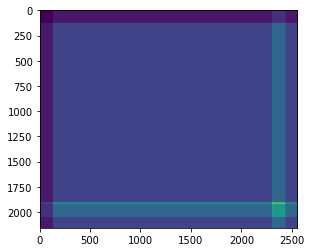

In [10]:
plt.imshow(num_pred_matrix)

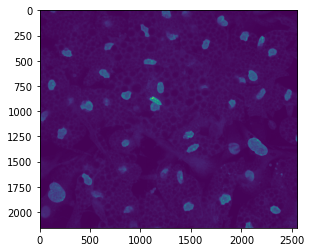

In [11]:
plt.imshow(img_reconstructed)

In [12]:
np.abs(img_reconstructed - img).sum()

0.0

In [13]:
import glob
import os
from monai.transforms import Compose, ToTensor

from data_utils import *

In [14]:
data_dir = "/data/*"
batch_size = 8

# collect instances
inputs = [
    sorted(glob.glob(os.path.join(data_dir, f'*A04Z0{i}*.tif'), recursive=True))
    for i in range(1,8)
]
targets = [
    sorted(glob.glob(os.path.join(data_dir, f'*C0{i}.tif'), recursive=True))
    for i in range(1,4)
]
# merge inputs and targets
all_data = inputs + targets
# match the slices and match all of the data for one input instance
data_all_ch = list(zip(*all_data))
data_all_ch[0]

('/data/20x_images/AssayPlate_Greiner_#655090_B03_T0001F001L01A04Z01C04.tif',
 '/data/20x_images/AssayPlate_Greiner_#655090_B03_T0001F001L01A04Z02C04.tif',
 '/data/20x_images/AssayPlate_Greiner_#655090_B03_T0001F001L01A04Z03C04.tif',
 '/data/20x_images/AssayPlate_Greiner_#655090_B03_T0001F001L01A04Z04C04.tif',
 '/data/20x_images/AssayPlate_Greiner_#655090_B03_T0001F001L01A04Z05C04.tif',
 '/data/20x_images/AssayPlate_Greiner_#655090_B03_T0001F001L01A04Z06C04.tif',
 '/data/20x_images/AssayPlate_Greiner_#655090_B03_T0001F001L01A04Z07C04.tif',
 '/data/20x_images/AssayPlate_Greiner_#655090_B03_T0001F001L01A01Z01C01.tif',
 '/data/20x_images/AssayPlate_Greiner_#655090_B03_T0001F001L01A02Z01C02.tif',
 '/data/20x_images/AssayPlate_Greiner_#655090_B03_T0001F001L01A03Z01C03.tif')

In [15]:
train_split, val_split = split_train_val(data_all_ch, N_valid_per_magn=2)

trans_val = MozartTheComposer(
    [
        ToTensor()
    ]
)

val_dataset = OverlappyGridyDataset(
    data=val_split[0],
    data_reader=PILReader(),
    patch_size=256,
    overlap_ratio=0.5
)

validation_loader = DataLoader(
    val_dataset,
    batch_size=batch_size
    #num_workers=4 #multiprocessing.cpu_count(),
)

In [25]:
validation_loader.dataset.merge_patches

In [16]:
a = []
for i, batch in enumerate(validation_loader):
    a.append(batch)

In [17]:
a[0][0].shape

torch.Size([8, 1, 10, 256, 256])

In [18]:
pred_patches = []
batch_size = 8

for i, batch in enumerate(validation_loader):
    batch_size = batch[0].shape[0]
    for j in range(batch_size):
        pred_patches.append(batch[0][j,0,:,:,:])

In [19]:
pred_image = val_dataset.merge_patches(pred_patches)

In [20]:
pred_image.shape

(10, 2154, 2554)

In [21]:
pred_patches[0].shape

torch.Size([10, 256, 256])